In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qiskit.providers.fake_provider as fp
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import Sampler
from qiskit.visualization import circuit_drawer, plot_gate_map
from qiskit_algorithms import EstimationProblem, AmplitudeEstimation
from utility import get_min_cx_brute

# QAE 돌리기

## A & Q 정의

In [19]:
class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)

In [20]:
class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)
        
    def power(self, k):
        """
        # implement the efficient power of Q
        원래는 위의 #만 적혀있었음.
        이게 안쓰이나 싶었는데 쓰임.
        EstimationProblem instance 선언할 때 grover_operator arg를 받는데,
        grover_operator.power식으로 쓰이는듯?
        power function을 정의 안하면
        '각도를 2배로 하는 대신'
        '회로를 2번 돌려서 cx가 2배로 늘어남';;;;
        """
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [21]:
p = 0.34

In [22]:
A = BernoulliA(p)
Q = BernoulliQ(p)

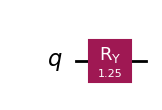

In [23]:
A.draw(output='mpl', style="iqp")

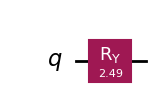

In [24]:
Q.draw(output='mpl', style="iqp")

## 전체 Circuit 만들기

In [25]:
problem = EstimationProblem(state_preparation=A,
                            grover_operator=Q,
                            objective_qubits=[0])

In [26]:
ae = AmplitudeEstimation(num_eval_qubits=4, sampler=Sampler())

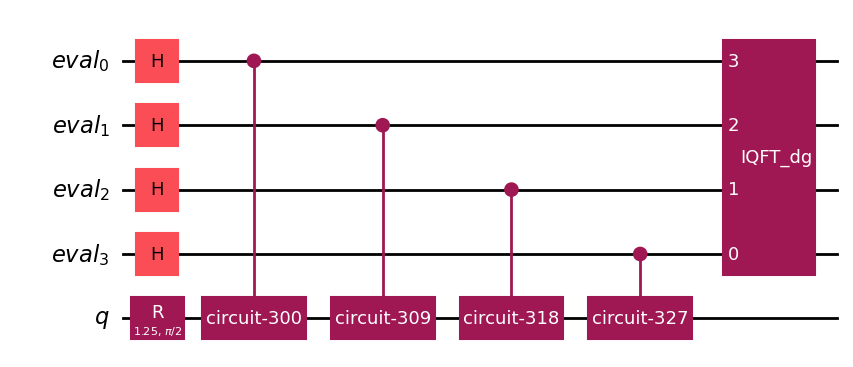

In [27]:
ae.construct_circuit(problem).decompose(reps=1).draw(output='mpl', style="iqp")

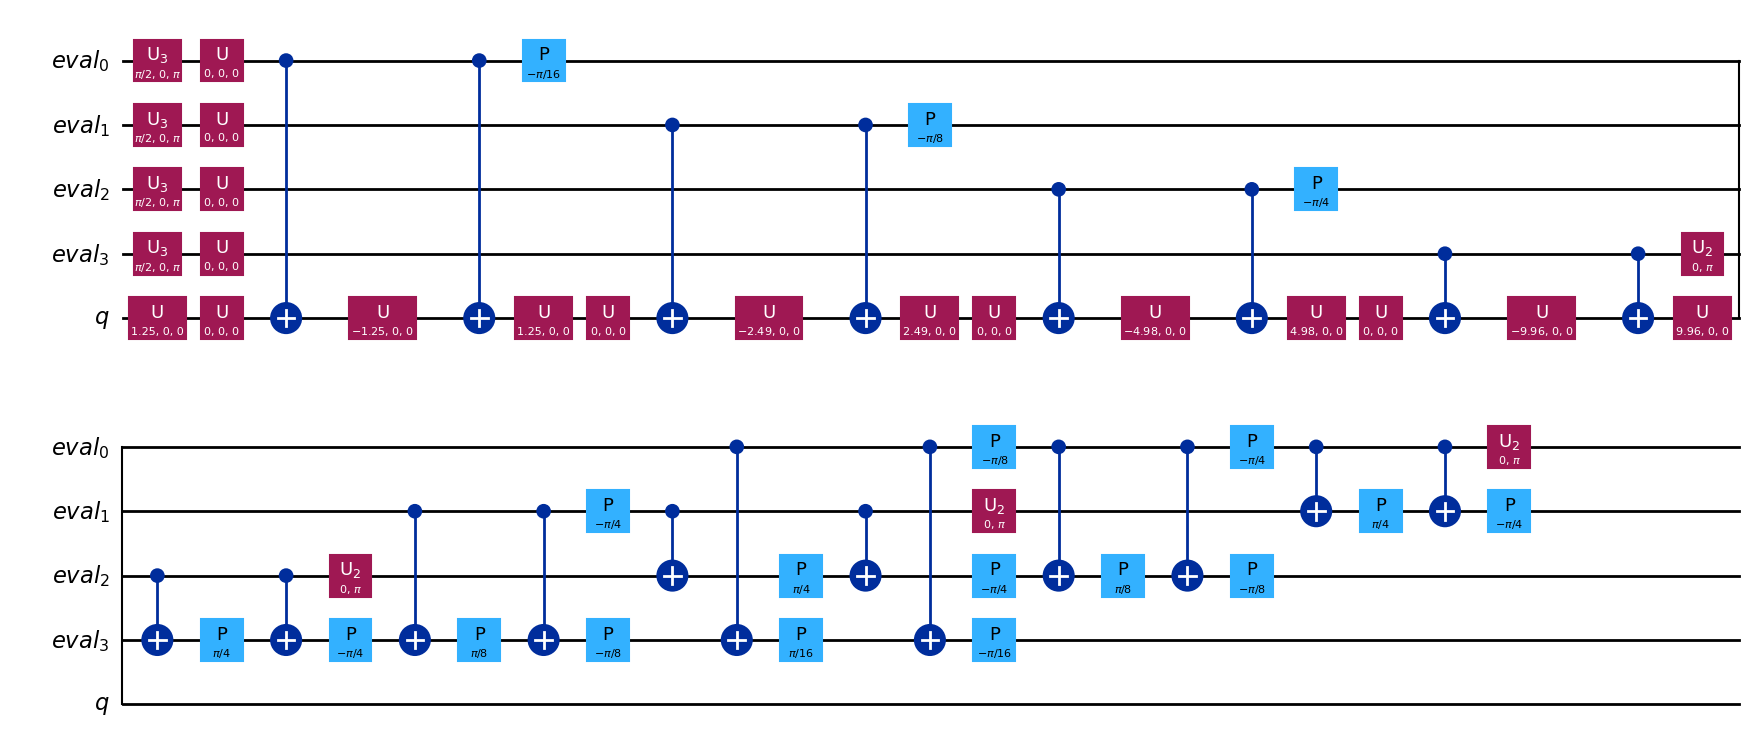

In [29]:
ae.construct_circuit(problem).decompose(reps=3).draw(output='mpl', style="iqp")

## 돌리고 결과 보기

In [12]:
ae_result = ae.estimate(problem)
print(f"True T-Bill: {p}, Estimated Value: {ae_result.estimation}")

True T-Bill: 0.34, Estimated Value: 0.3086583


In [15]:
ae_result.circuit_results

{'0000': 0.0029940485553865,
 '0001': 0.0015423886497446,
 '0010': 0.0198823536881134,
 '0011': 0.0198823536881134,
 '0100': 0.0105121921108288,
 '0101': 0.0023665960713756,
 '0110': 0.0023665960713756,
 '0111': 0.0105121921108288,
 '1000': 0.0039324292881738,
 '1001': 0.0017048883453804,
 '1010': 0.0046282700759769,
 '1011': 0.4547050518175847,
 '1100': 0.4547050518175846,
 '1101': 0.0046282700759769,
 '1110': 0.0017048883453804,
 '1111': 0.0039324292881738}

In [16]:
ae_result.samples

{0.0: 0.0029940485553865,
 1.0: 0.0015423886497446,
 0.5: 0.0397647073762268,
 0.1464466: 0.0210243842216576,
 0.8535534: 0.0047331921427512,
 0.0380602: 0.0078648585763476,
 0.9619398: 0.0034097766907608,
 0.6913417: 0.0092565401519538,
 0.3086583: 0.9094101036351693}

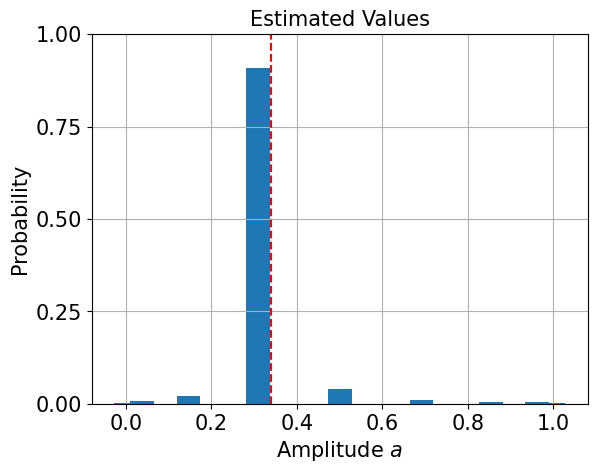

In [13]:
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

# CX 게이트 수

#### Fake Processor list & toplogies

In [17]:
# FakeTokyo, FakeGuadalupe, FakeYorktown, FakeWashington: Ref
# FakeSherbrooke, FakeCairo, FakeHanoi, FakeKolkata, FakeMumbai: 현재 운용중
backend = fp.FakeYorktown()

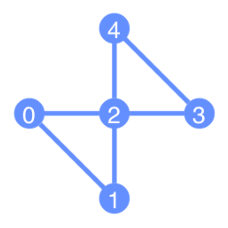

In [18]:
plot_gate_map(backend)

In [16]:
print(f'Num of qubit is : {backend.configuration().n_qubits}')

Num of qubit is : 5


## Yorktown 실험

### 4개 qubits(3개 evaluation qubits)

In [17]:
backend = fp.FakeYorktown()

In [18]:
ae = AmplitudeEstimation(num_eval_qubits=3, sampler=Sampler())

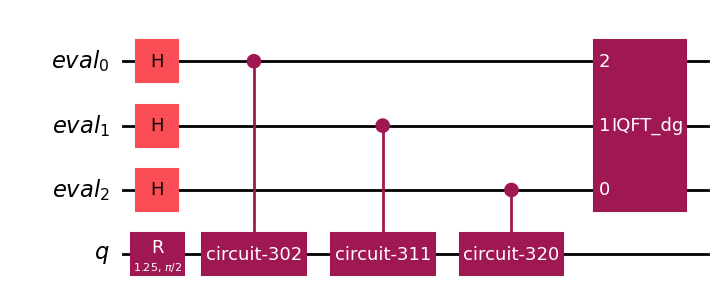

In [19]:
ae.construct_circuit(problem).decompose(reps=1).draw(output='mpl', style="iqp")

#### Backend 없이(이상적)

In [20]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).count_ops()['cx']

12

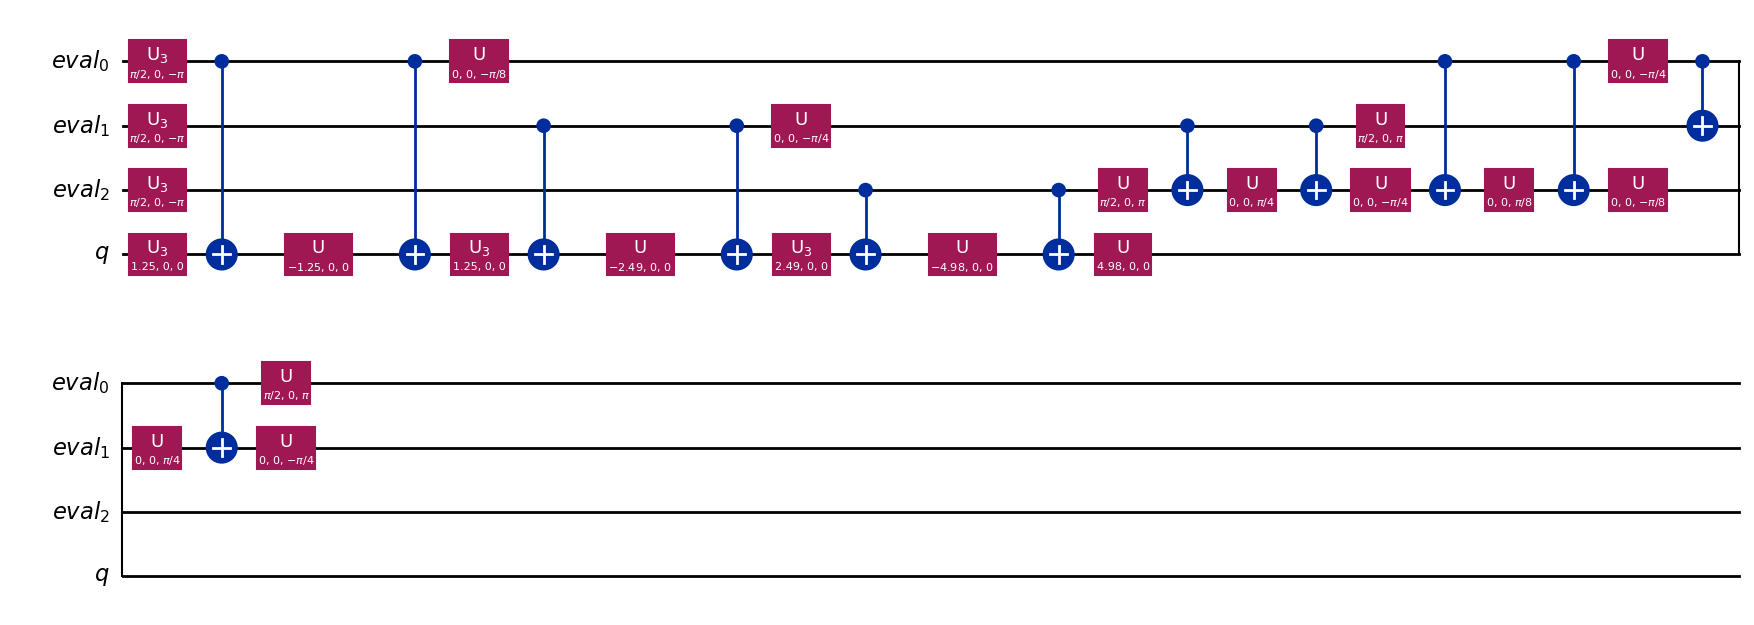

In [21]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).draw(output='mpl', style="iqp")

#### Backend 있지(실제)

In [22]:
transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend).count_ops()['cx']

15

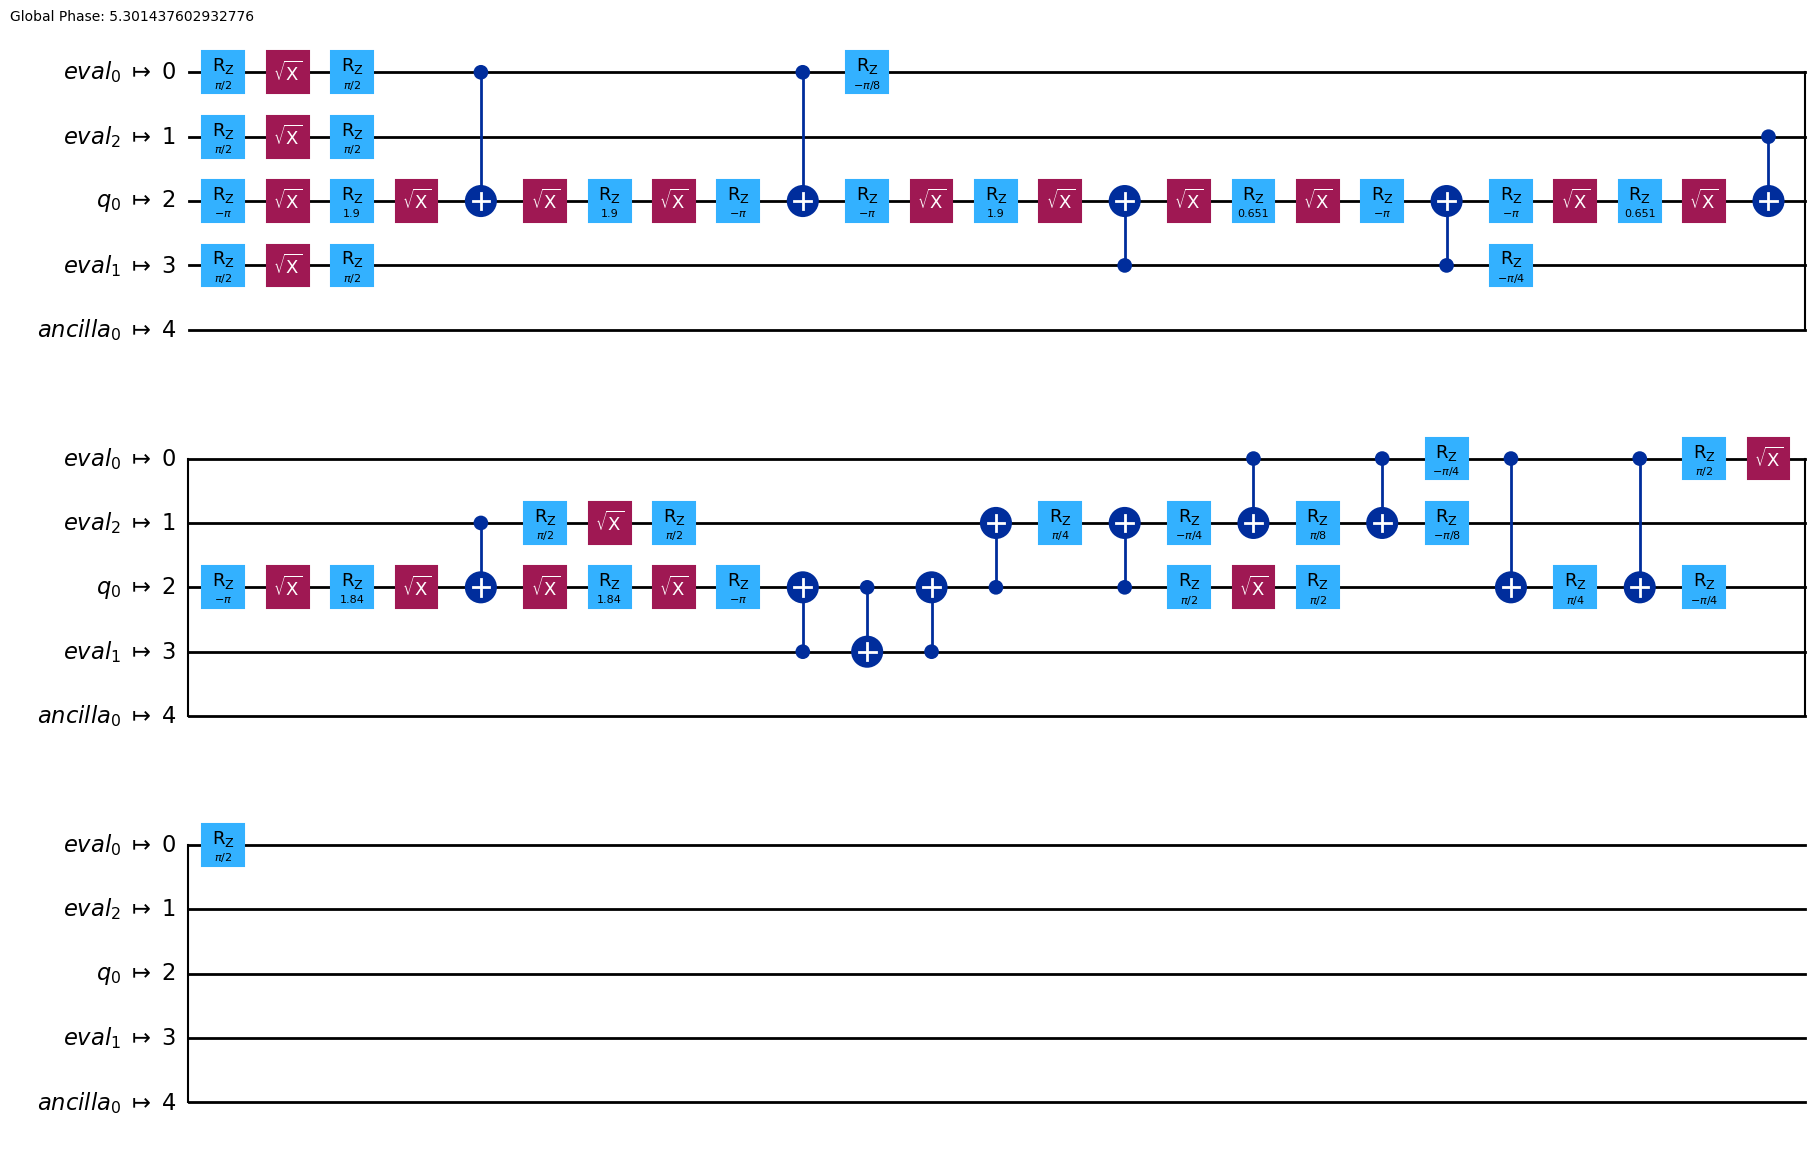

In [23]:
circuit_drawer(transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend), output='mpl', style="iqp")

### 5개 qubits(4개 evaluation qubits)

In [24]:
ae = AmplitudeEstimation(num_eval_qubits=4, sampler=Sampler())

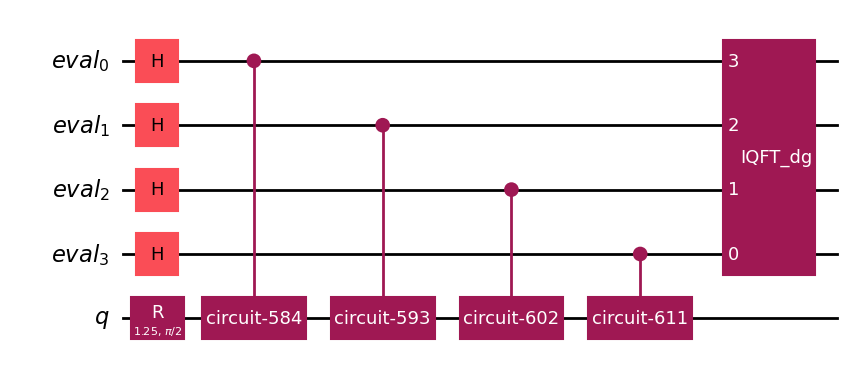

In [25]:
ae.construct_circuit(problem).decompose(reps=1).draw(output='mpl', style="iqp")

#### Backend 없이(이상적)

In [26]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).count_ops()['cx']

20

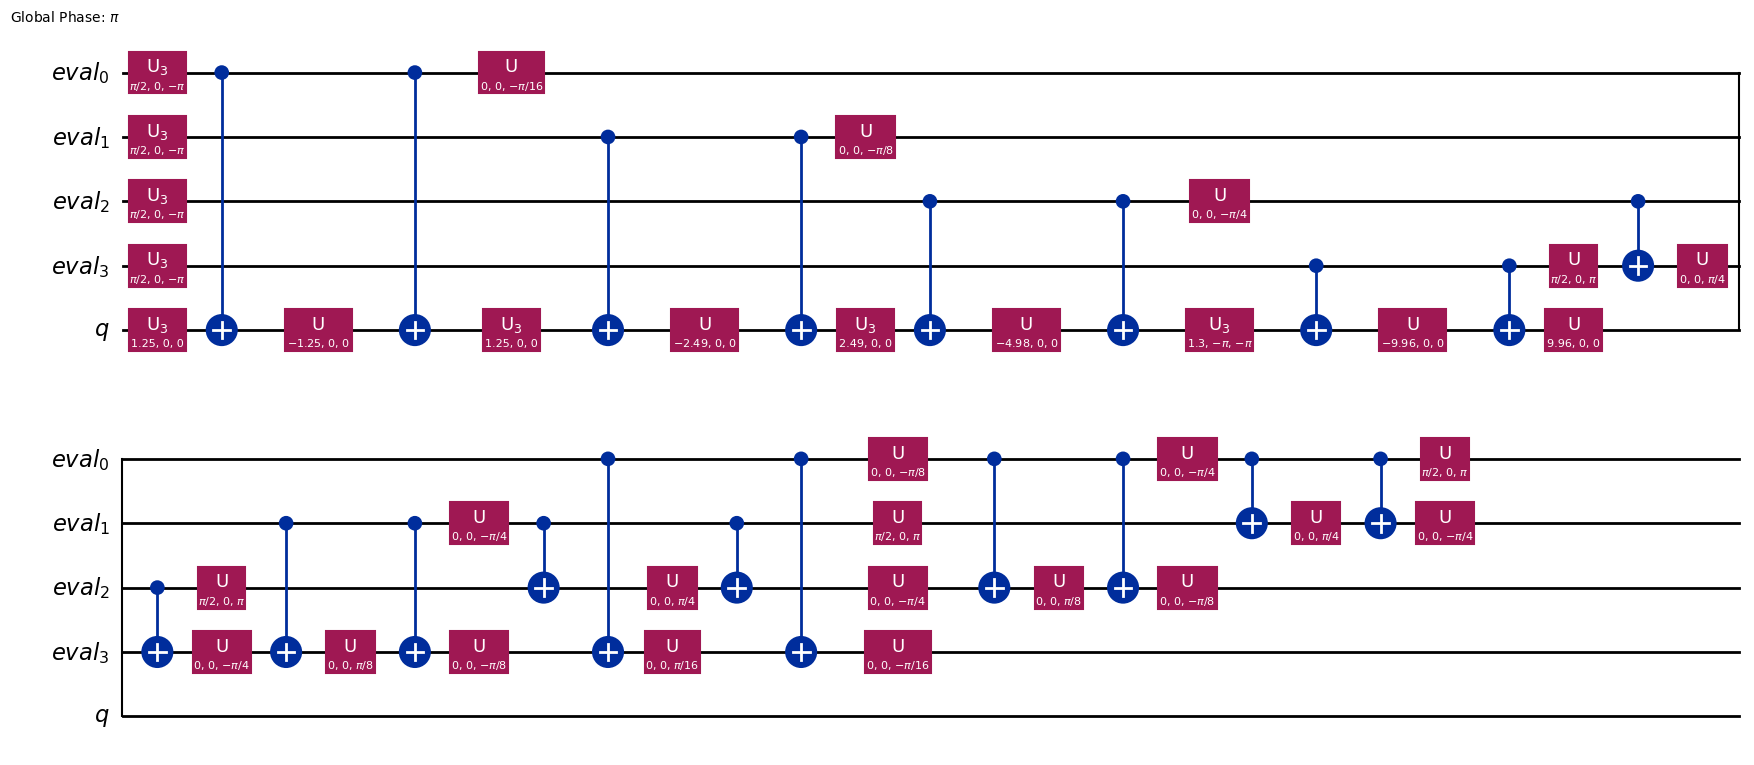

In [27]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).draw(output='mpl', style="iqp")

#### Backend 있지(실제)

In [28]:
transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend).count_ops()['cx']

26

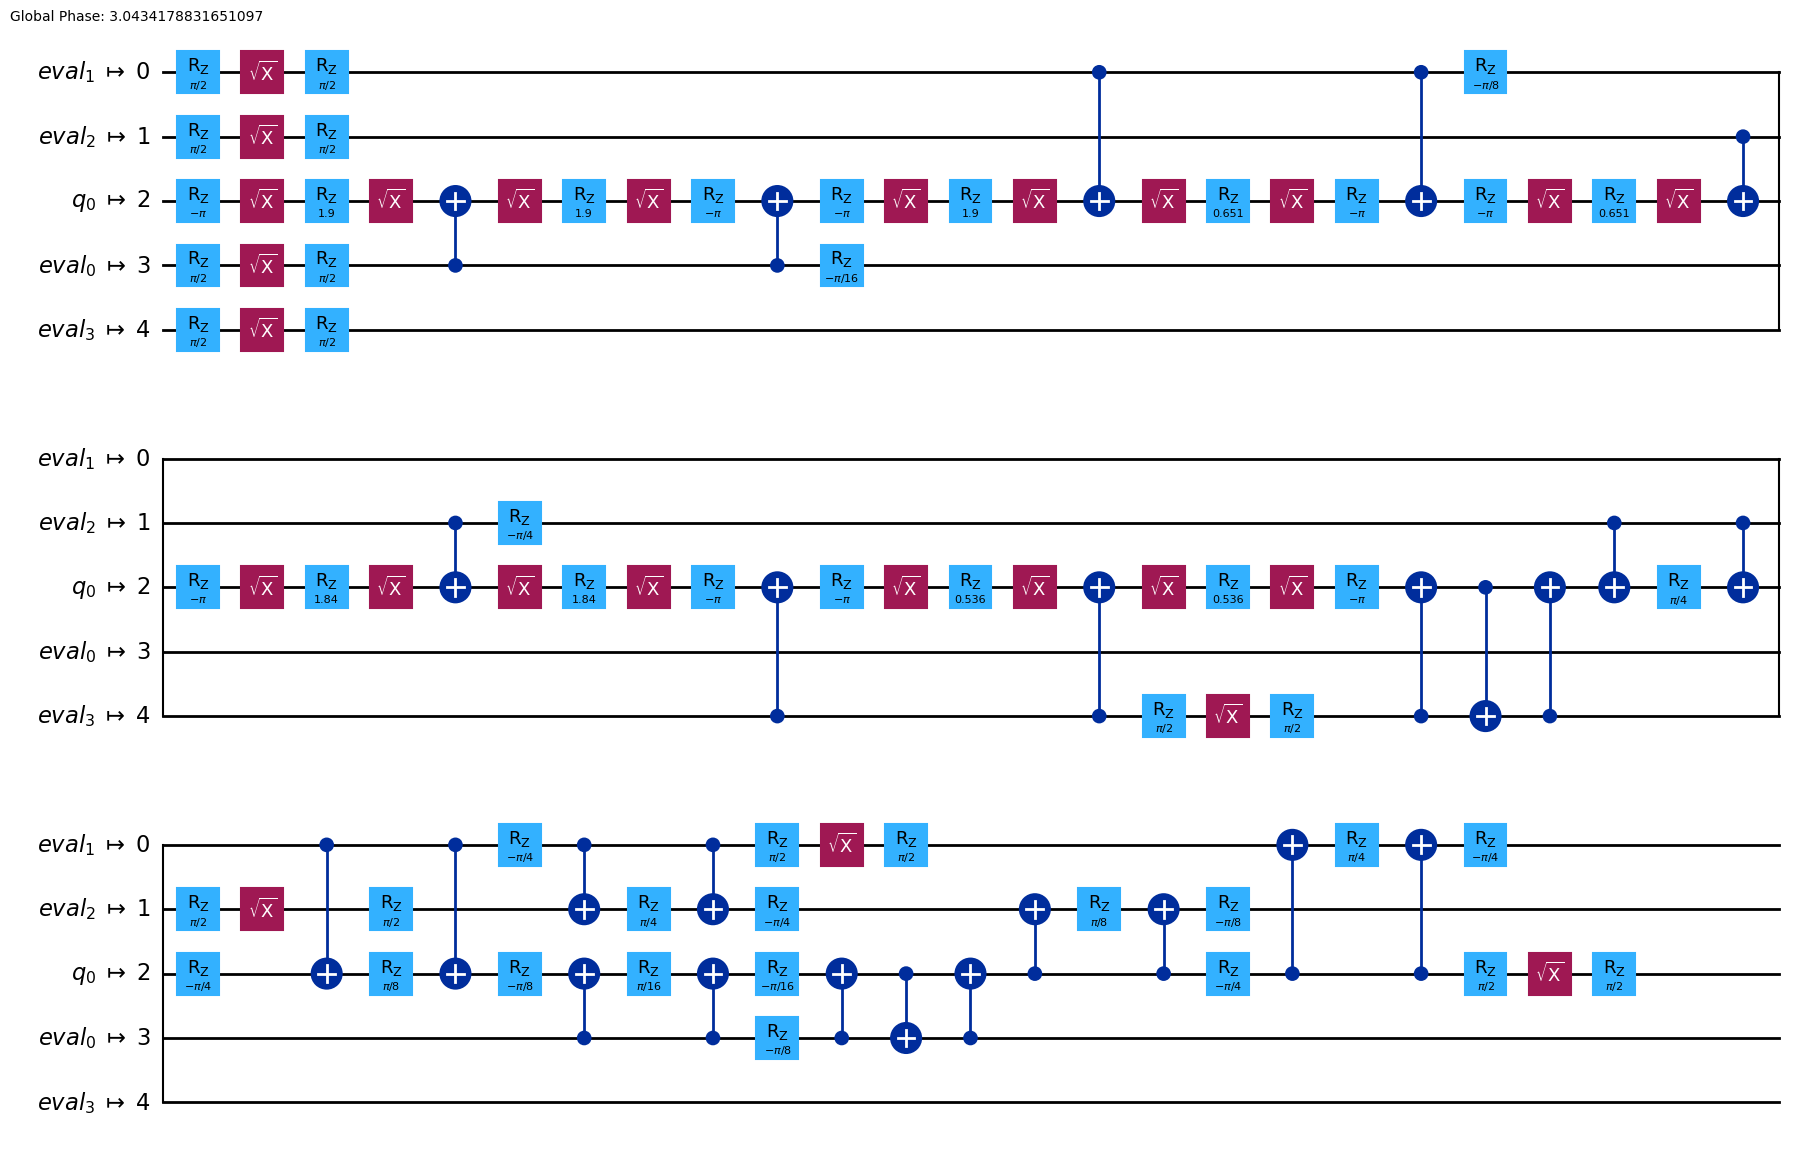

In [29]:
circuit_drawer(transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend), output='mpl', style="iqp")

## Tokyo 실험

### 4개 qubits(3개 evaluation qubits)

In [30]:
backend = fp.FakeTokyo()

In [31]:
ae = AmplitudeEstimation(num_eval_qubits=3, sampler=Sampler())

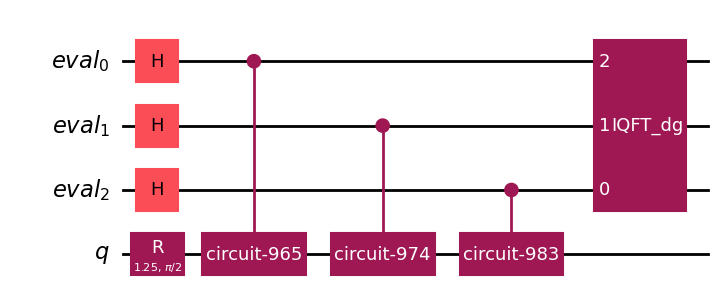

In [32]:
ae.construct_circuit(problem).decompose(reps=1).draw(output='mpl', style="iqp")

#### Backend 없이(이상적)

In [33]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).count_ops()['cx']

12

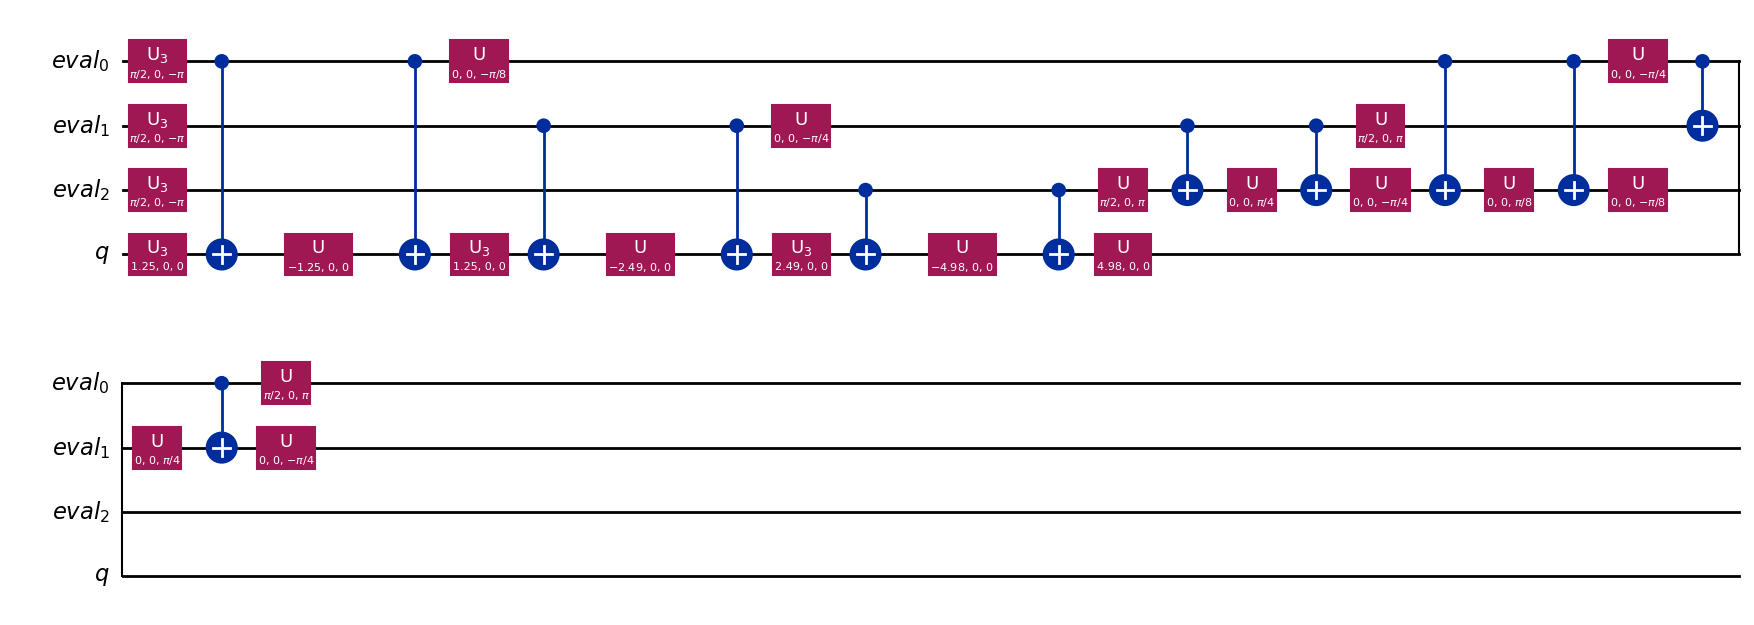

In [34]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).draw(output='mpl', style="iqp")

#### Backend 있지(실제)

In [35]:
transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend).count_ops()['cx']

12

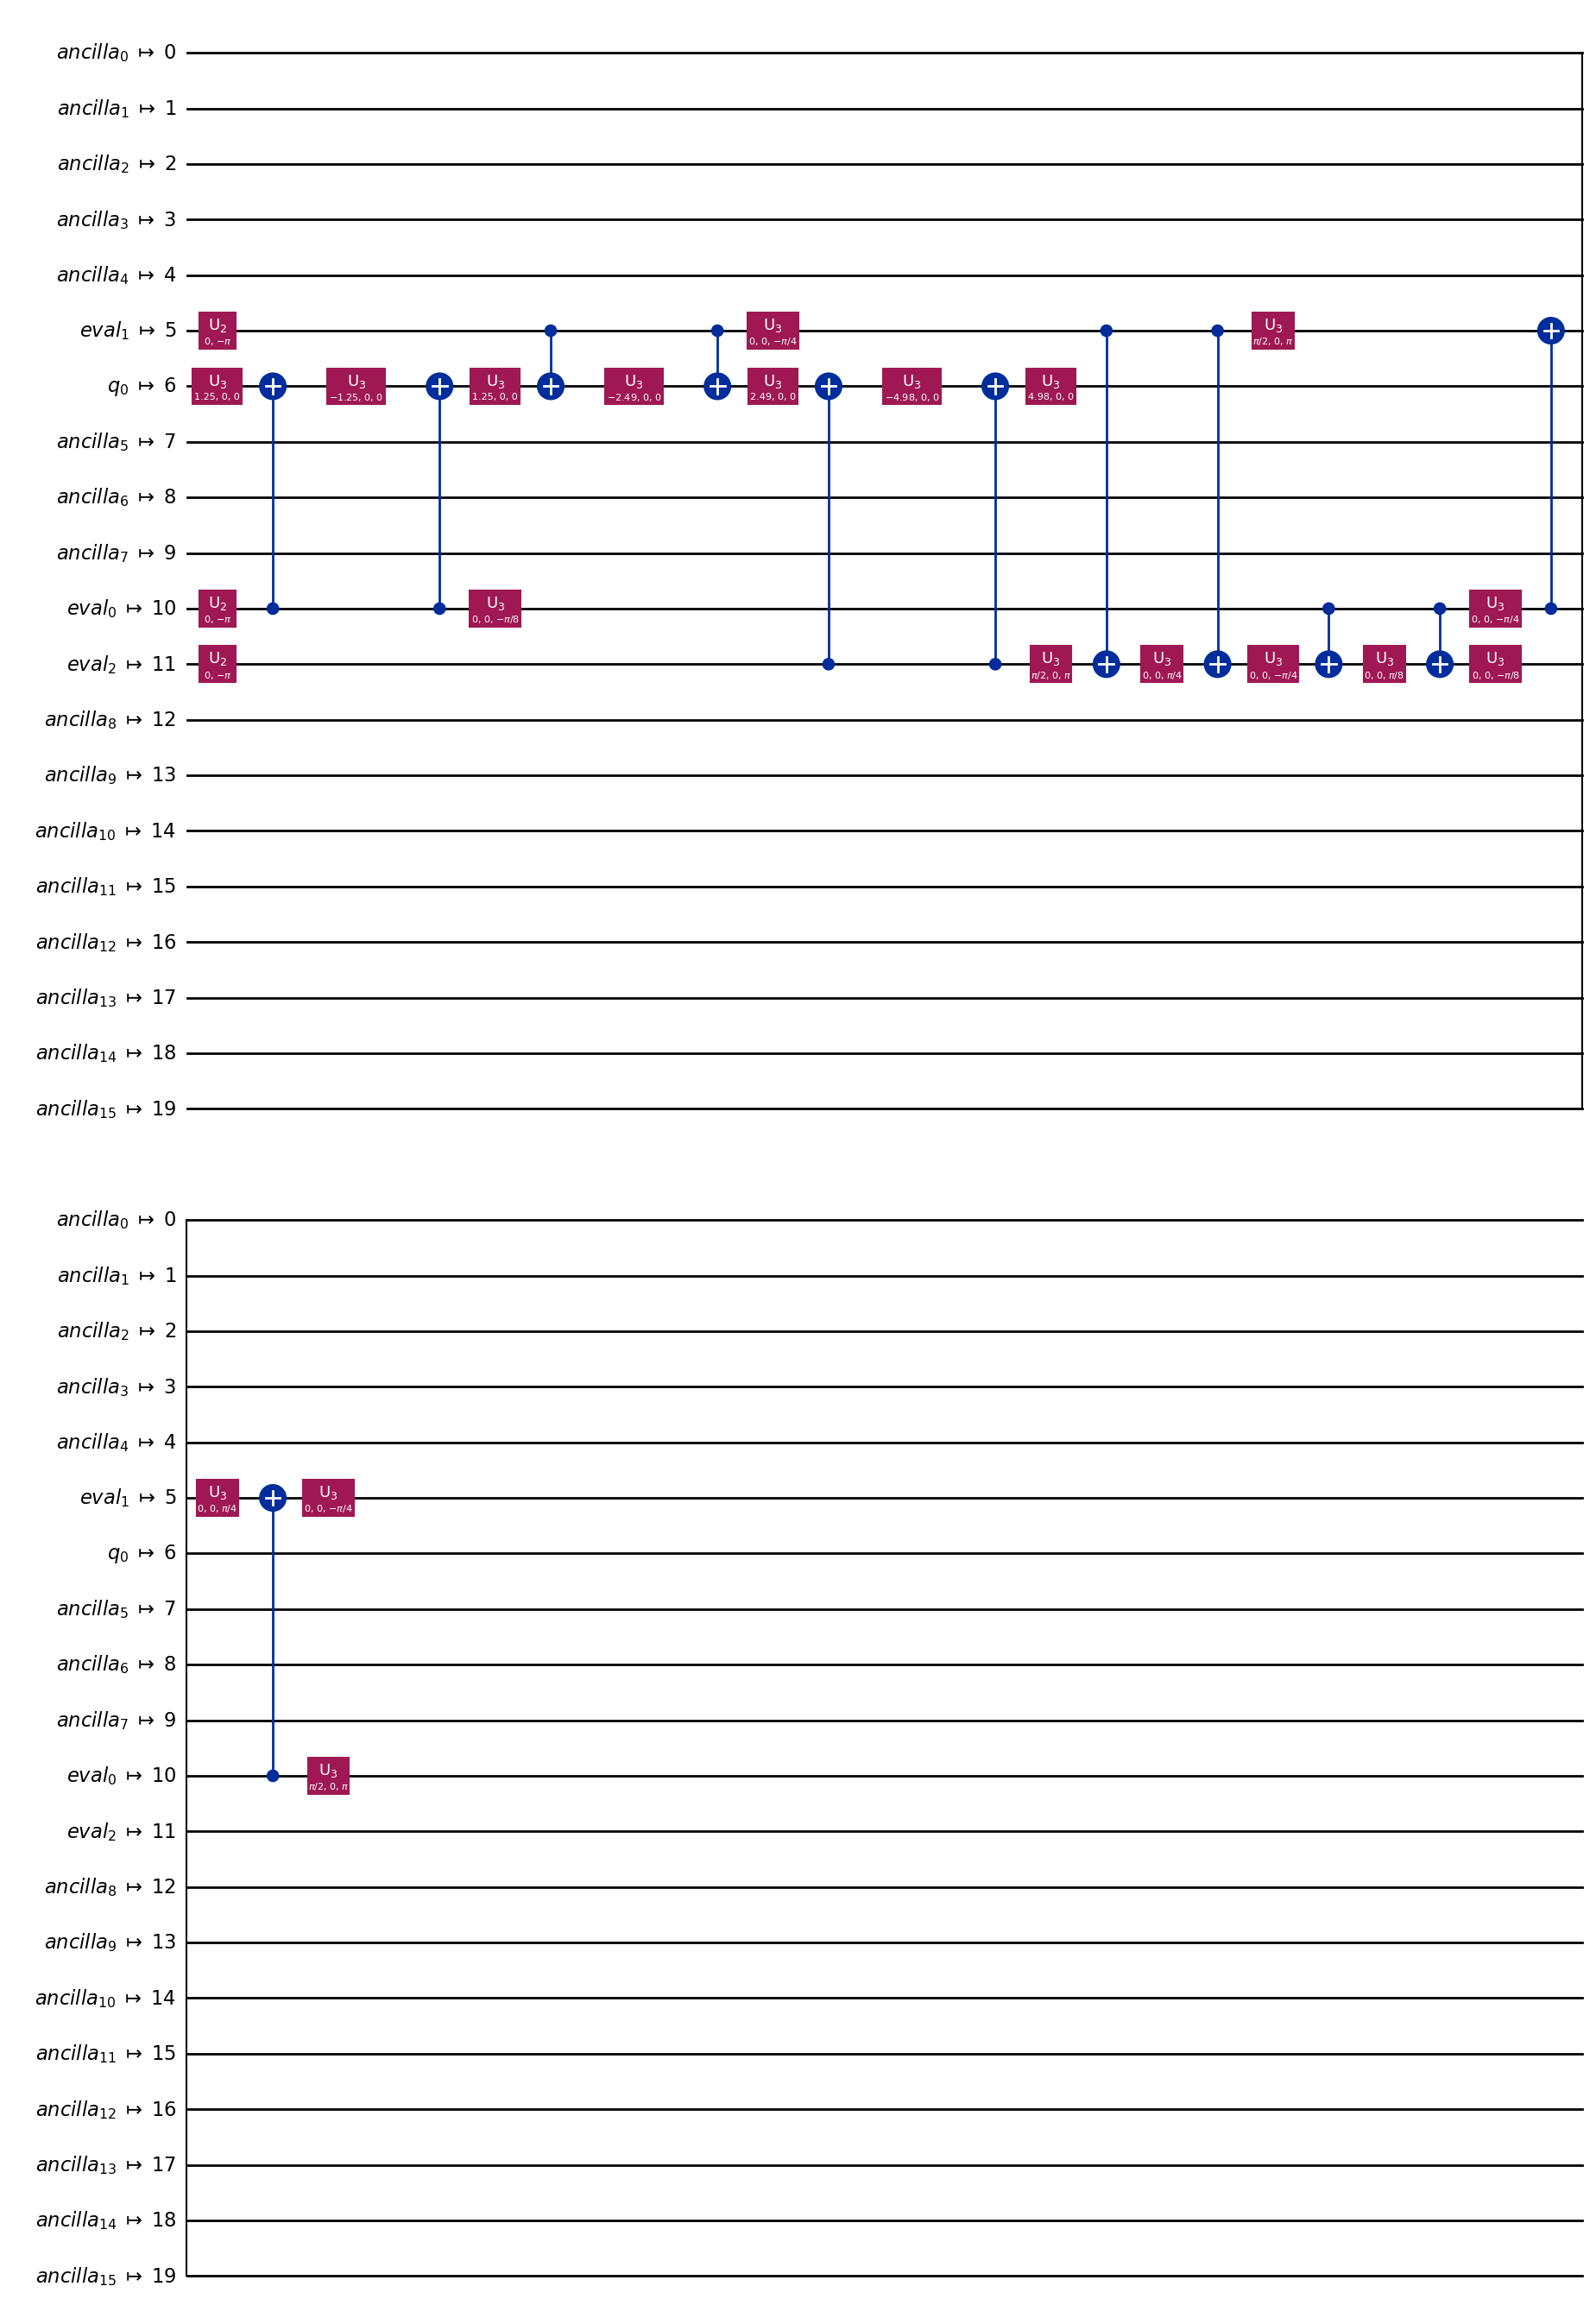

In [36]:
circuit_drawer(transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend), output='mpl', style="iqp")

### 5개 qubits(4개 evaluation qubits)

In [37]:
ae = AmplitudeEstimation(num_eval_qubits=4, sampler=Sampler())

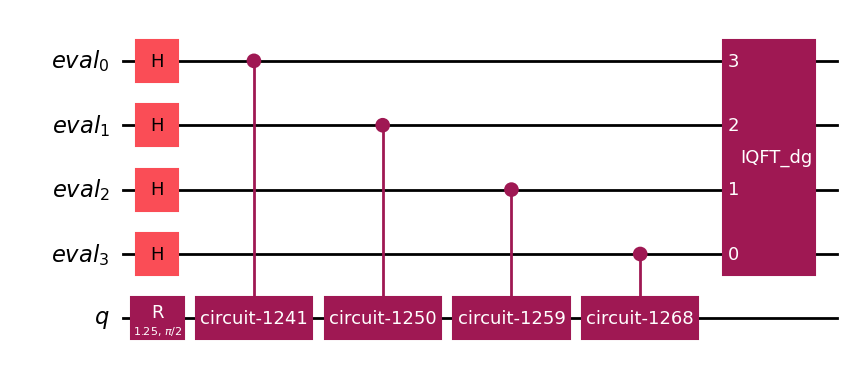

In [38]:
ae.construct_circuit(problem).decompose(reps=1).draw(output='mpl', style="iqp")

#### Backend 없이(이상적)

In [39]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).count_ops()['cx']

20

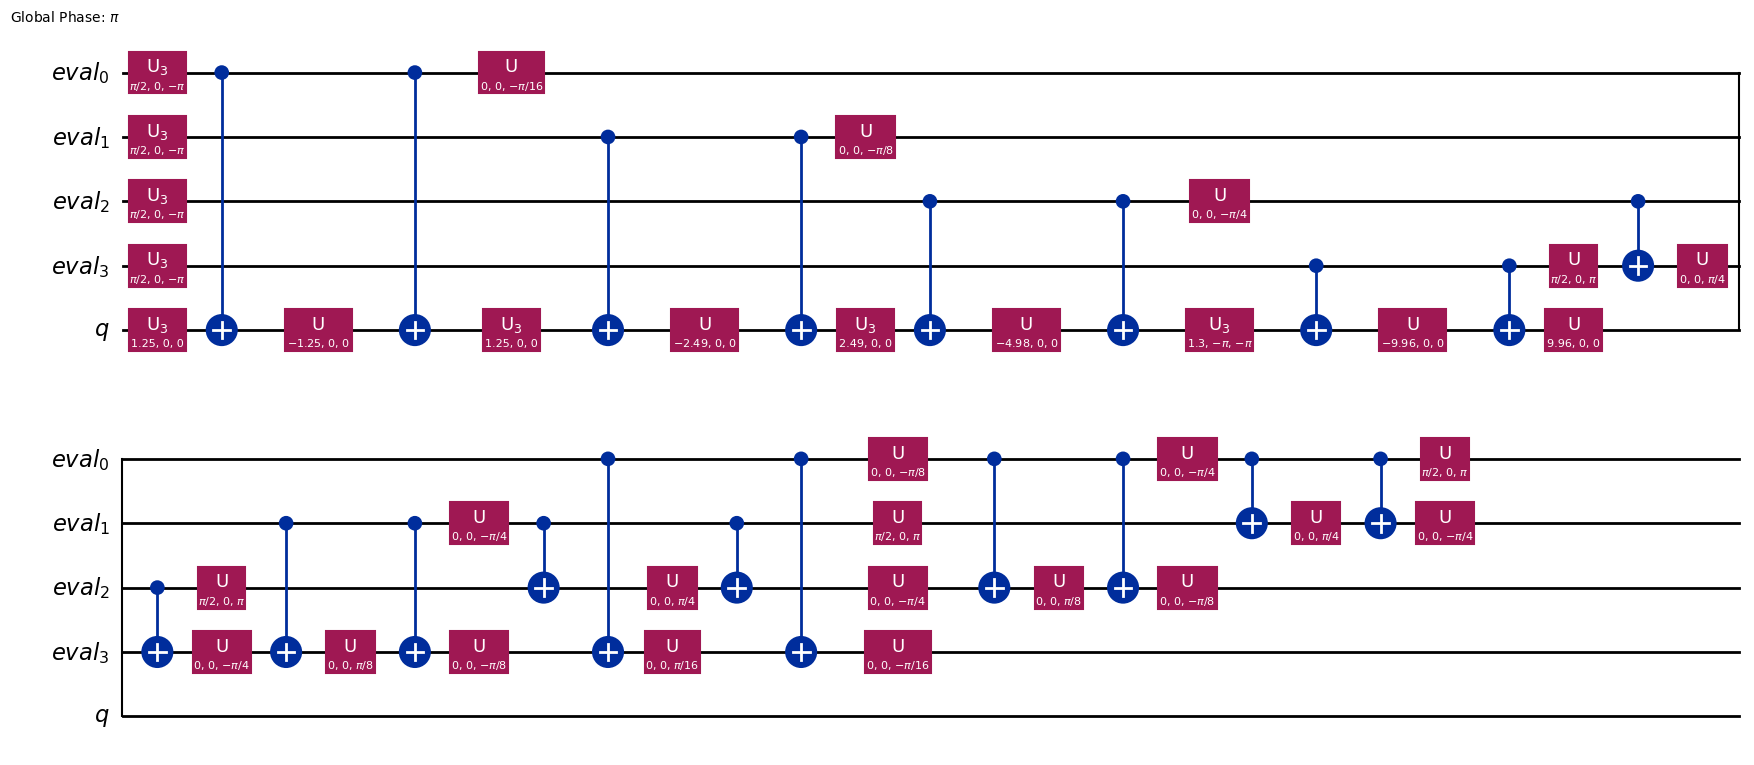

In [40]:
transpile(ae.construct_circuit(problem).decompose(reps=8)).draw(output='mpl', style="iqp")

#### Backend 있지(실제)

이거 이론상 23개 나와야 최소인데, 보통 26개 나옴(보통 고르면 26개 나오게 고름), 계속 해봐야함

In [52]:
get_min_cx_brute(qcircuit=ae.construct_circuit(problem), 
                 backend=backend, 
                 num_of_shot=10)

23

In [44]:
transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend).count_ops()['cx']

26

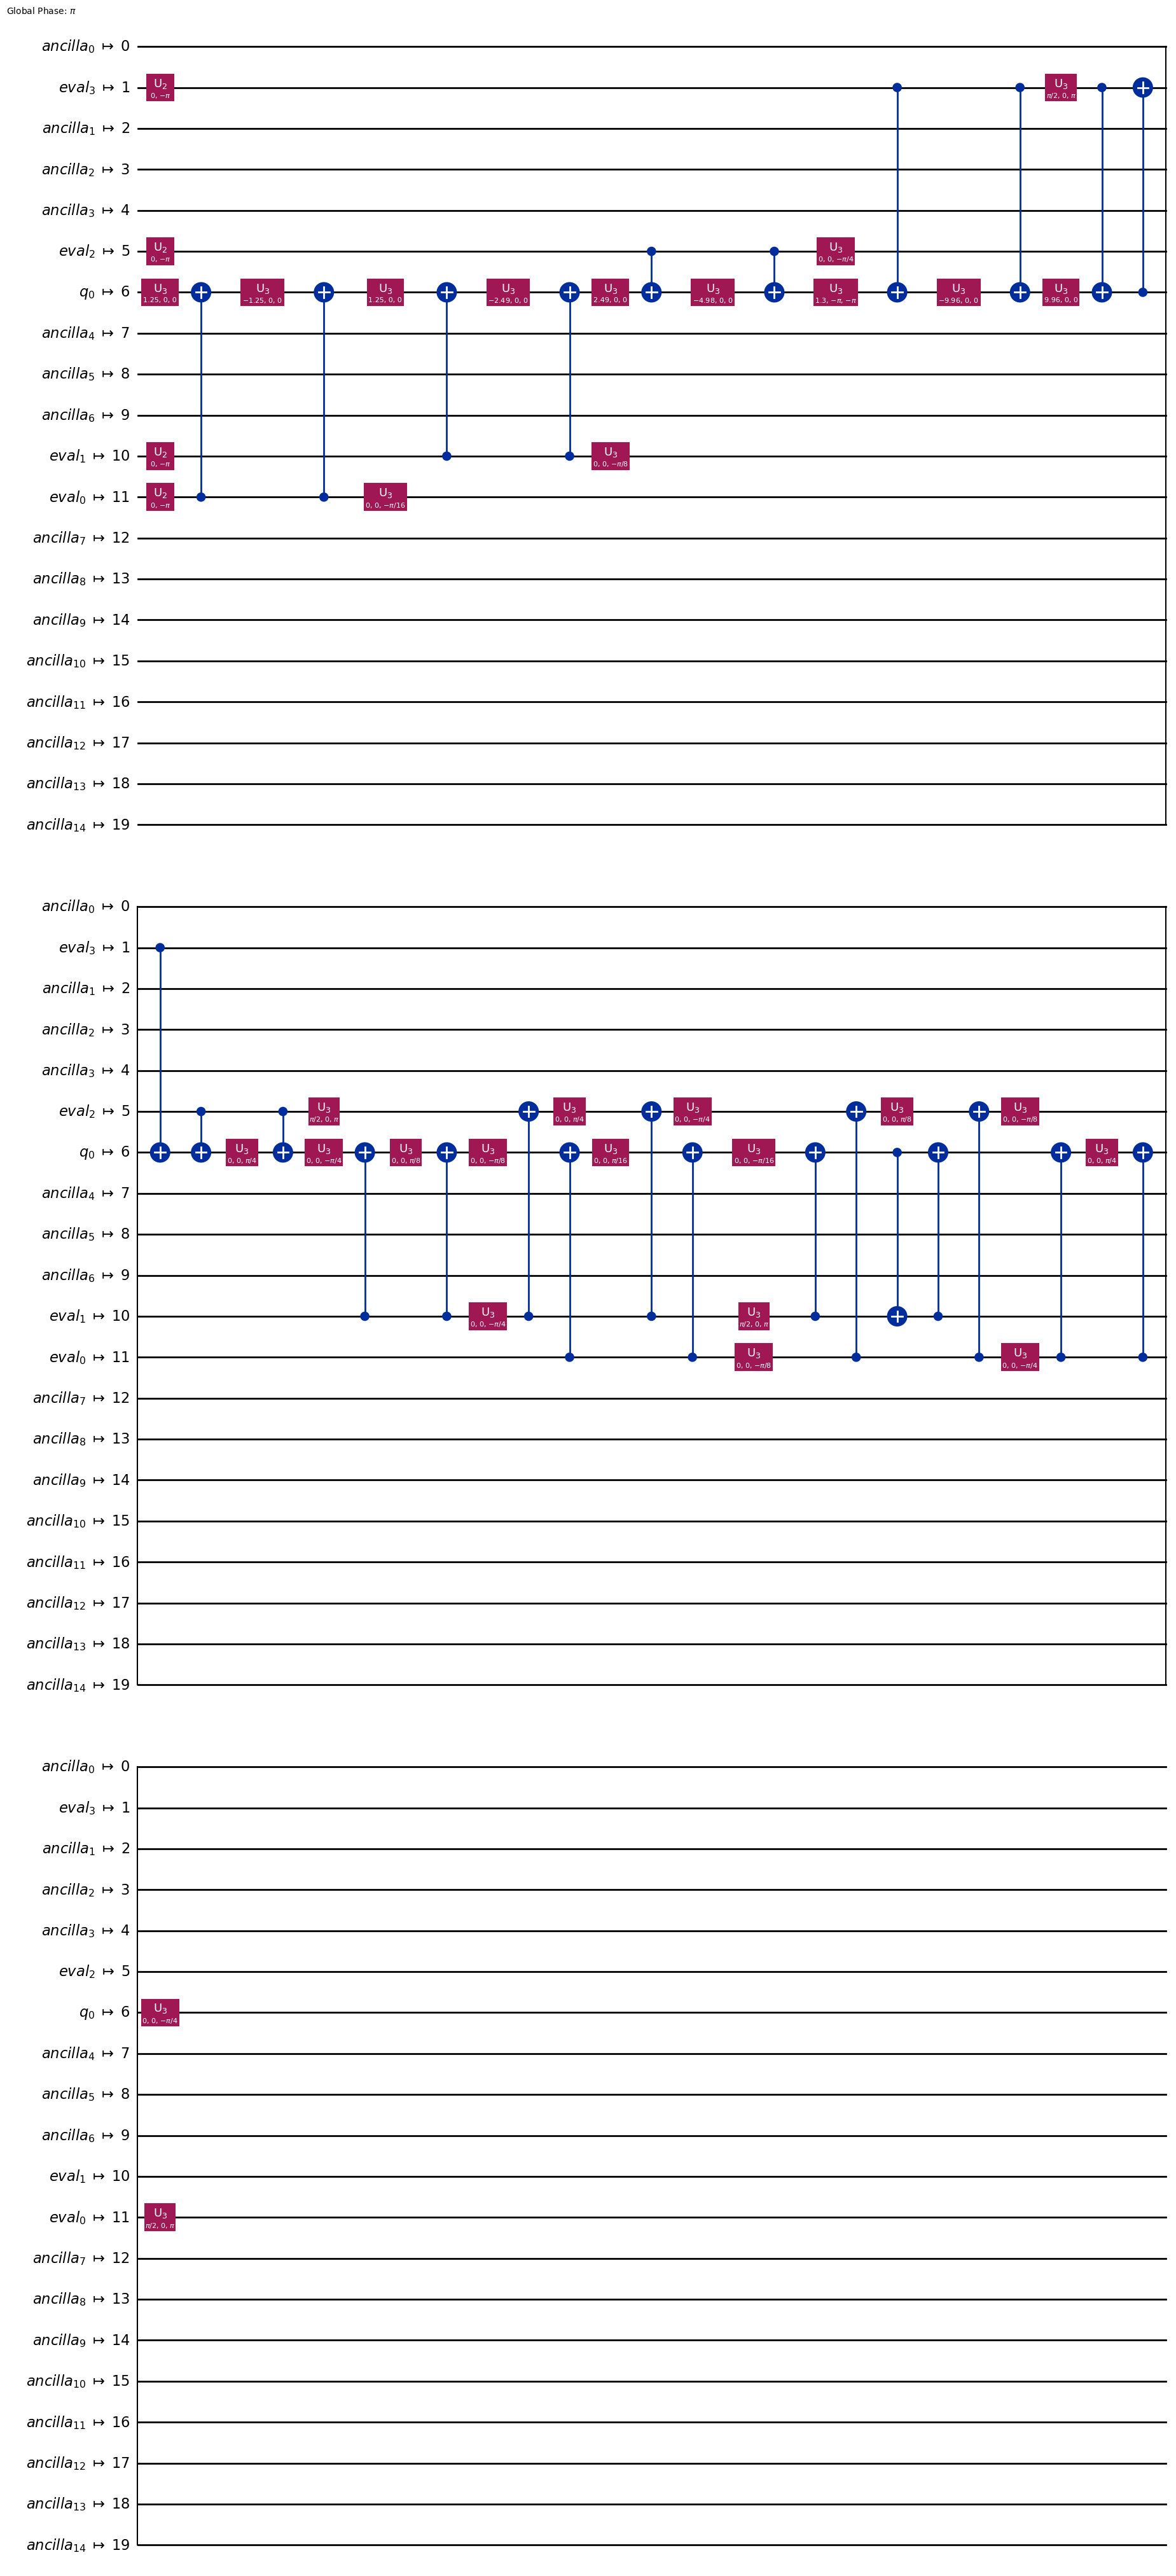

In [45]:
circuit_drawer(transpile(ae.construct_circuit(problem).decompose(reps=8), backend=backend), output='mpl', style="iqp")

In [ ]:
basis_gates = ["h", "ry", "cx",'u']